In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA

In [65]:
df = pd.read_parquet("../data/processed/daily_with_finbert_and_indicators.parquet")

In [66]:
print(df.shape)
df.head()

(2490, 793)


,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,momentum_10,volatility_10,sma_10,momentum_20,volatility_20,sma_20,rsi_14,cumulative_return,running_max,drawdown
0,AAPL,2024-05-01,169.580002,172.710007,169.110001,169.300003,50383100.0,0.022032,[],0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022032,0.022032,0.000000
1,AAPL,2024-05-02,172.509995,173.419998,170.889999,173.029999,94214900.0,0.059816,[],0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.081848,0.081848,0.000000
2,AAPL,2024-05-03,186.649994,187.000000,182.660004,183.380005,163224100.0,-0.009107,[],0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072741,0.081848,-0.009107
3,AAPL,2024-05-06,182.350006,184.199997,180.419998,181.710007,78569700.0,0.003797,[],0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076539,0.081848,-0.005310
4,AAPL,2024-05-07,183.449997,184.899994,181.320007,182.399994,77305800.0,0.001864,[From Apple to Wayfair: A Lot of Earnings Resu...,0.030524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.078403,0.081848,-0.003445


In [ ]:
df["num_headlines"] = df["headlines"].apply(lambda x: len(x))

['finbert_754',
 'finbert_755',
 'finbert_756',
 'finbert_757',
 'finbert_758',
 'finbert_759',
 'finbert_760',
 'finbert_761',
 'finbert_762',
 'finbert_763',
 'finbert_764',
 'finbert_765',
 'finbert_766',
 'finbert_767',
 'sent_pos',
 'sent_neu',
 'sent_neg',
 'momentum_5',
 'volatility_5',
 'sma_5',
 'momentum_10',
 'volatility_10',
 'sma_10',
 'momentum_20',
 'volatility_20',
 'sma_20',
 'rsi_14',
 'cumulative_return',
 'running_max',
 'drawdown']

In [68]:
def plot_stock_metrics(
    df,
    metric="open",
    N=5,
    y_min=None,
    y_max=None,
    rotation=45
):
    """
    Plot time series metric (e.g., 'open', 'close', 'momentum_10', 'volatility_10') over time by ticker.

    Parameters:
        df (pd.DataFrame): Must include ['ticker', 'date', metric]
        metric (str): Metric column to plot (e.g., 'open', 'close', 'momentum_10', 'volatility_10')
                      Use 'both_price' to show open + close together.
        N (int): Show every Nth x-tick label
        y_min, y_max (float): Y-axis limits
        rotation (int): X-axis label rotation
    """
    import matplotlib.pyplot as plt
    from matplotlib.cm import get_cmap

    tickers = df["ticker"].unique()
    colors = get_cmap("tab10", len(tickers))

    plt.figure(figsize=(12, 6))

    for i, ticker in enumerate(tickers):
        df_t = df[df["ticker"] == ticker]
        color = colors(i)

        if metric == "both_price":
            plt.plot(df_t["date"], df_t["open"], label=f"{ticker} open", color=color)
            plt.plot(df_t["date"], df_t["close"], label=f"{ticker} close", color=color, linestyle="--")
        else:
            plt.plot(df_t["date"], df_t[metric], label=ticker, color=color)

    plt.legend(title="Ticker")
    ticks = plt.xticks()[0]
    plt.xticks(
        ticks=ticks[::N],
        labels=[label.get_text() for i, label in enumerate(plt.gca().get_xticklabels()) if i % N == 0],
        rotation=rotation
    )

    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)

    plt.xlabel("Date")
    plt.ylabel(metric.replace("_", " ").capitalize())
    plt.title(f"{metric.replace('_', ' ').capitalize()} Over Time")
    plt.tight_layout()
    plt.show()


C:\Users\asacco\AppData\Local\Temp\ipykernel_5048\535149673.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("tab10", len(tickers))


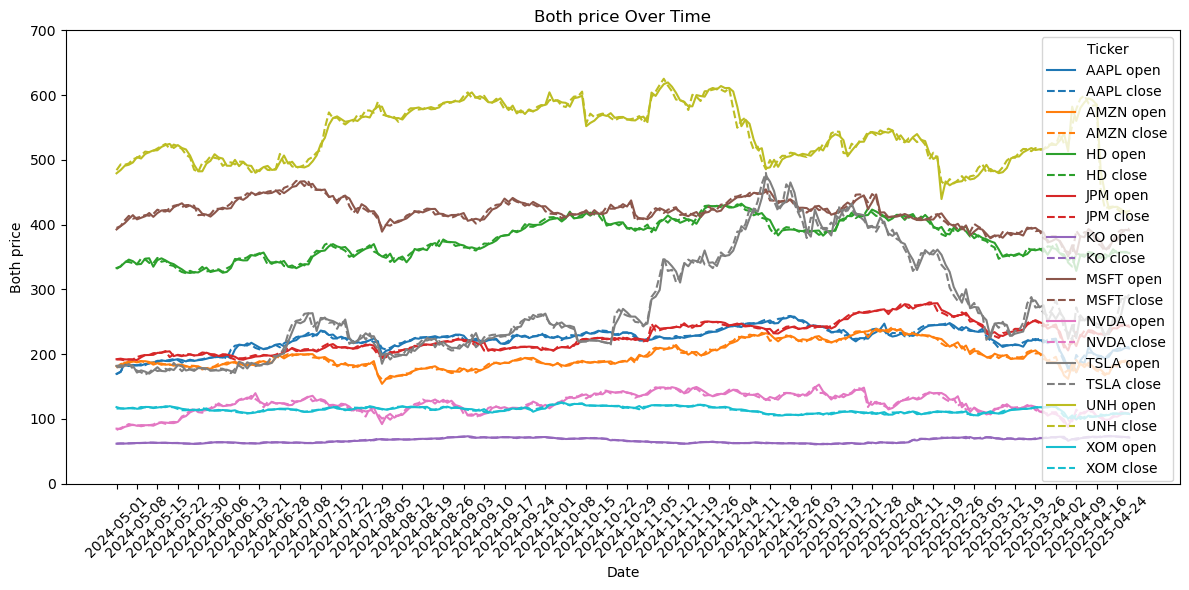

In [16]:
plot_stock_metrics(df, "both_price", 5, 0, 700, 45)

C:\Users\asacco\AppData\Local\Temp\ipykernel_5048\535149673.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("tab10", len(tickers))


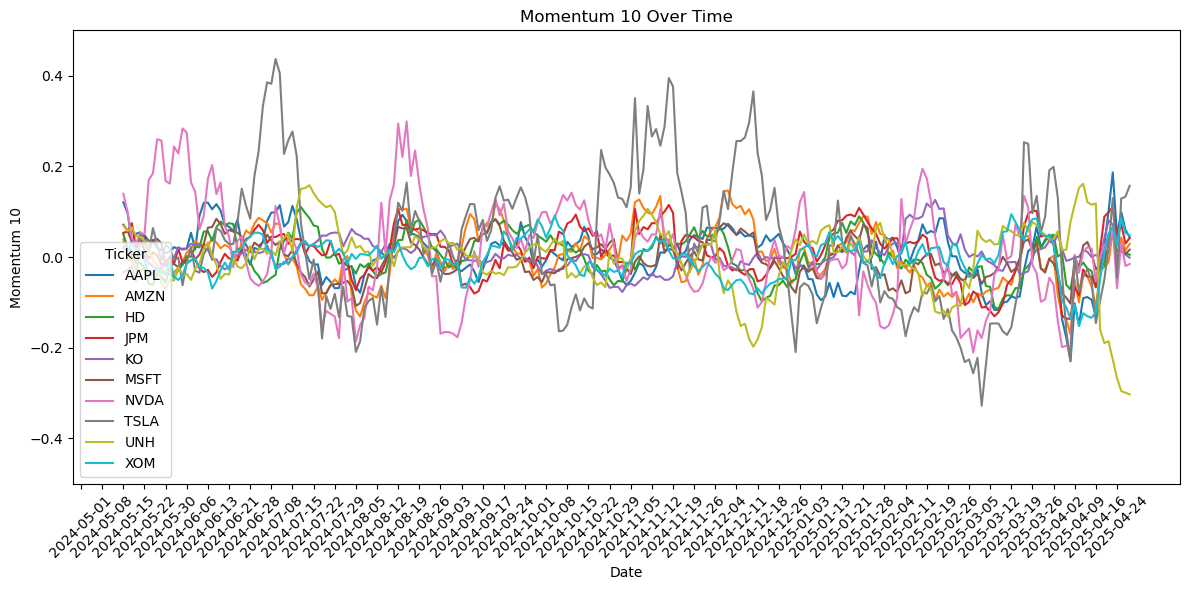

In [69]:
plot_stock_metrics(df, "momentum_10", 5, -0.50, 0.50, 45)

C:\Users\asacco\AppData\Local\Temp\ipykernel_5048\535149673.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("tab10", len(tickers))


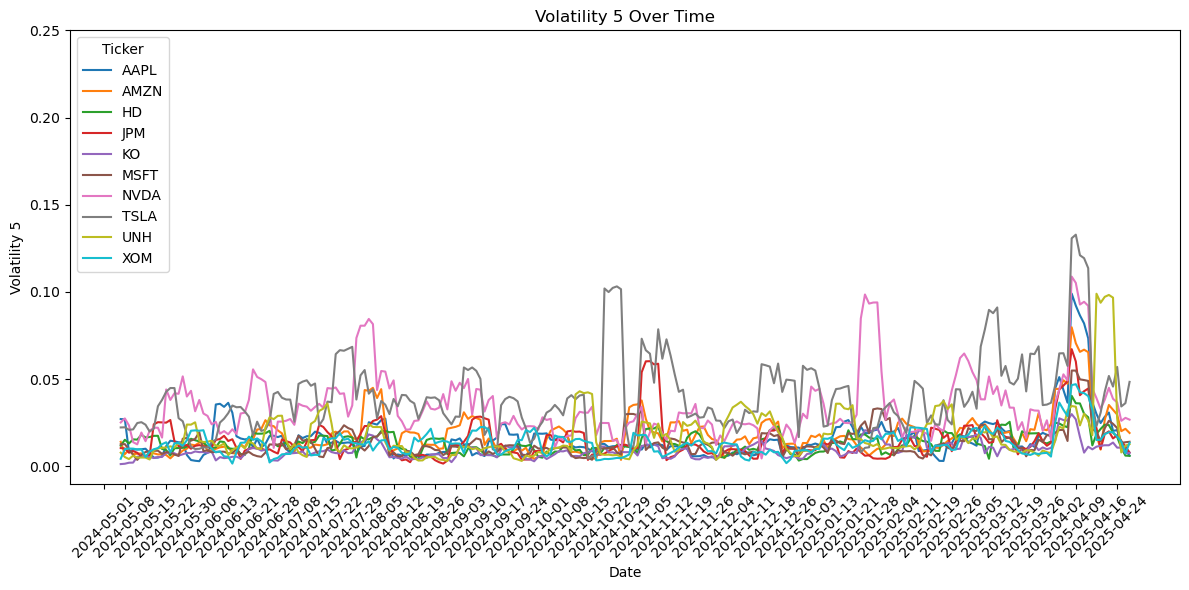

In [70]:
plot_stock_metrics(df, "volatility_5", 5, -0.01, 0.25, 45)

C:\Users\asacco\AppData\Local\Temp\ipykernel_5048\535149673.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("tab10", len(tickers))


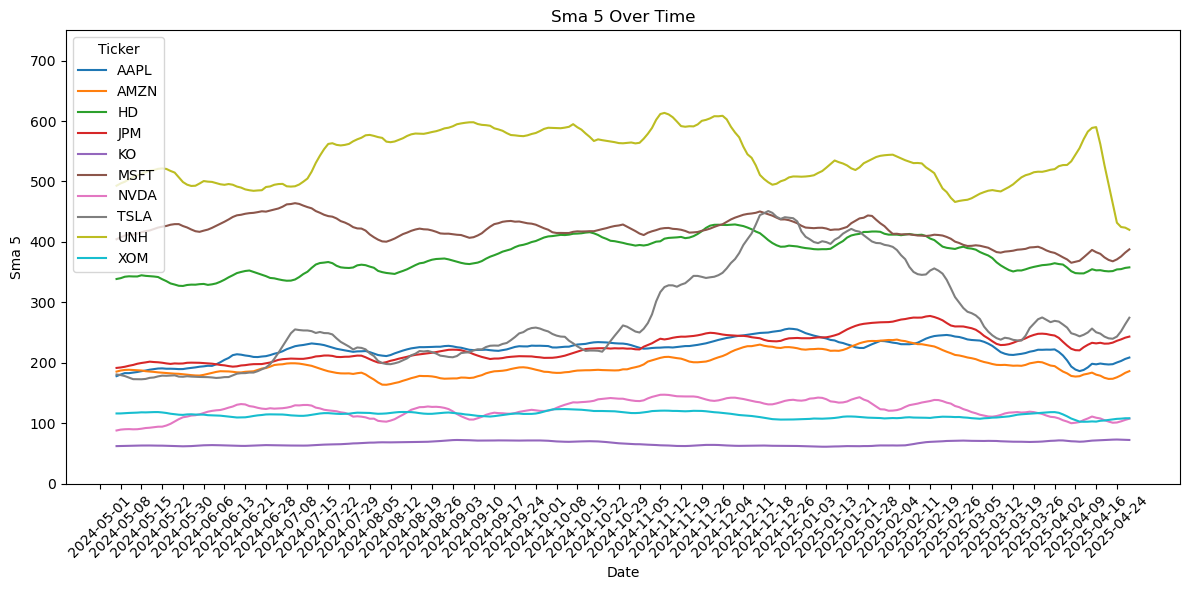

In [71]:
plot_stock_metrics(df, "sma_5", 5, 0, 750, 45)

## Distribution of returns as T + 1

<Axes: >

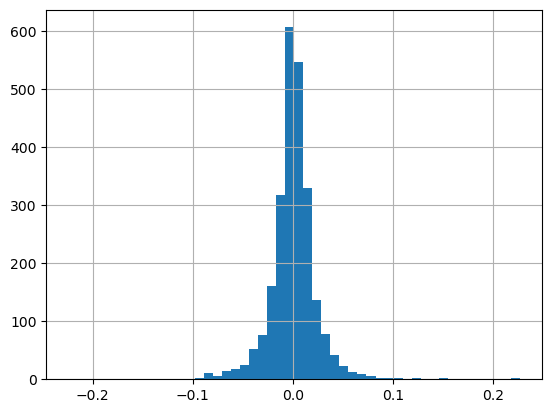

In [72]:
df["return_t+1"].hist(bins=50)

In [73]:
df["volume"].describe()

count    2.490000e+03
mean     5.672354e+07
std      9.608911e+07
min      1.319500e+06
25%      8.629275e+06
50%      1.890255e+07
75%      5.277095e+07
max      8.350650e+08
Name: volume, dtype: float64

In [74]:
df.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'volume',
       'return_t+1', 'headlines', 'finbert_0',
       ...
       'momentum_10', 'volatility_10', 'sma_10', 'momentum_20',
       'volatility_20', 'sma_20', 'rsi_14', 'cumulative_return', 'running_max',
       'drawdown'],
      dtype='object', length=793)

## Heatmap of open, close, and next day returns
- Open and close price are highly-correlated
- Open, close, and volume are not correlated with returns in T+1

In [30]:
df.columns.tolist()

['ticker',
 'date',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'return_t+1',
 'headlines',
 'bert_0',
 'bert_1',
 'bert_2',
 'bert_3',
 'bert_4',
 'bert_5',
 'bert_6',
 'bert_7',
 'bert_8',
 'bert_9',
 'bert_10',
 'bert_11',
 'bert_12',
 'bert_13',
 'bert_14',
 'bert_15',
 'bert_16',
 'bert_17',
 'bert_18',
 'bert_19',
 'bert_20',
 'bert_21',
 'bert_22',
 'bert_23',
 'bert_24',
 'bert_25',
 'bert_26',
 'bert_27',
 'bert_28',
 'bert_29',
 'bert_30',
 'bert_31',
 'bert_32',
 'bert_33',
 'bert_34',
 'bert_35',
 'bert_36',
 'bert_37',
 'bert_38',
 'bert_39',
 'bert_40',
 'bert_41',
 'bert_42',
 'bert_43',
 'bert_44',
 'bert_45',
 'bert_46',
 'bert_47',
 'bert_48',
 'bert_49',
 'bert_50',
 'bert_51',
 'bert_52',
 'bert_53',
 'bert_54',
 'bert_55',
 'bert_56',
 'bert_57',
 'bert_58',
 'bert_59',
 'bert_60',
 'bert_61',
 'bert_62',
 'bert_63',
 'bert_64',
 'bert_65',
 'bert_66',
 'bert_67',
 'bert_68',
 'bert_69',
 'bert_70',
 'bert_71',
 'bert_72',
 'bert_73',
 'bert_74',
 'bert_75',
 '

<Axes: >

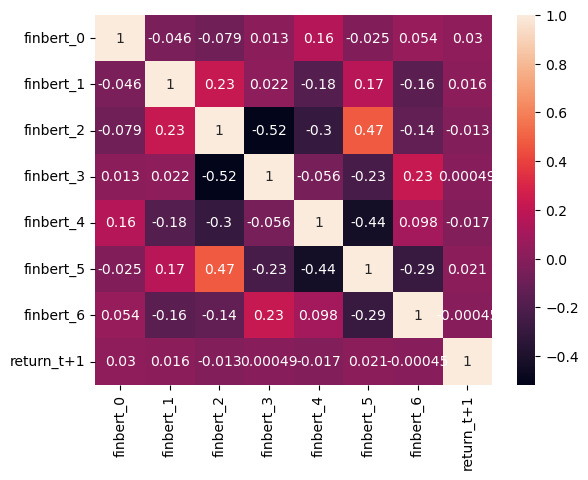

In [ ]:
sns.heatmap(df[[col for col in df.columns if col.startswith("finbert")][:7] + ["return_t+1"]].corr(), annot=True)

<Axes: >

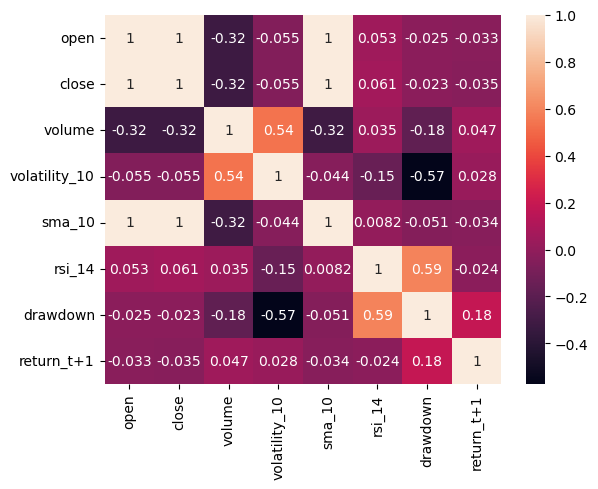

In [ ]:
# Open and close price are highly-correlated
# Open, close, and volume are not correlated with returns in T+1
sns.heatmap(df[["open", "close", "volume", "volatility_10", "sma_10", "rsi_14", "drawdown", "return_t+1"]].corr(), annot=True)

<Axes: >

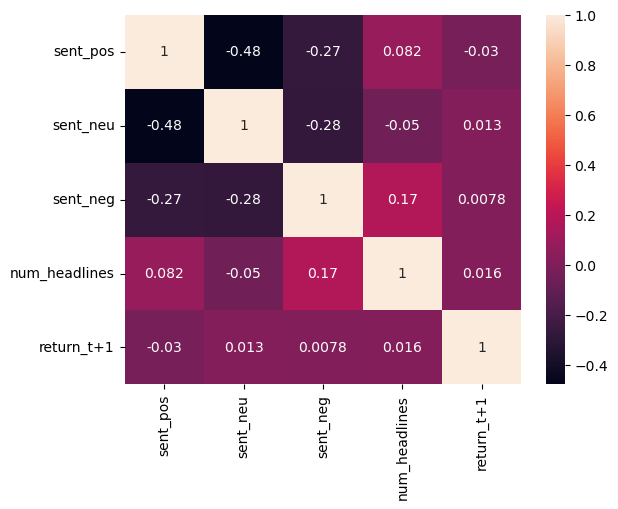

In [ ]:


sns.heatmap(df[['sent_pos', 'sent_neu', 'sent_neg', 'num_headlines', "return_t+1"]].corr(), annot=True)


## Number of headlines per day by ticker

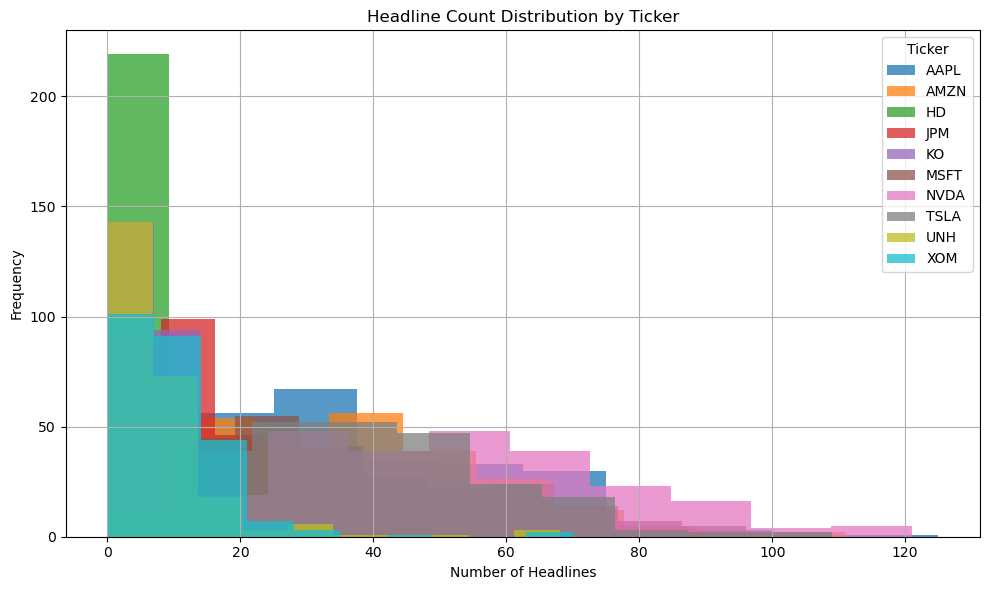

In [81]:
plt.figure(figsize=(10, 6))

for ticker, group in df.groupby("ticker"):
    group["num_headlines"].hist(alpha=0.75, bins=10, label=ticker)

plt.legend(title="Ticker")
plt.xlabel("Number of Headlines")
plt.ylabel("Frequency")
plt.title("Headline Count Distribution by Ticker")
plt.tight_layout()
plt.show()


## Average returns by week (could use to calibrate across multiple stocks)

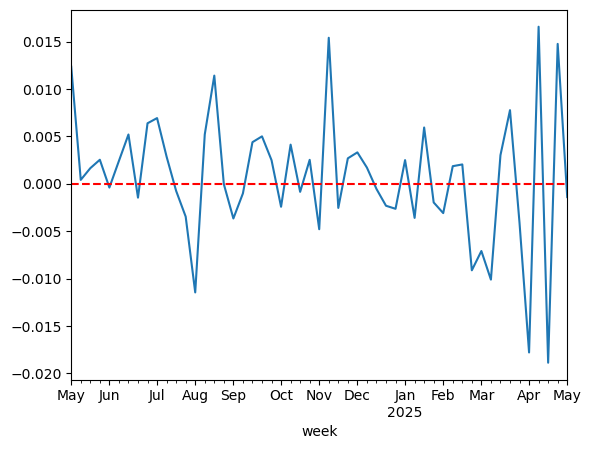

In [56]:
df["week"] = pd.to_datetime(df["date"]).dt.to_period("W")
df.groupby("week")["return_t+1"].mean().plot()
plt.axhline(0, linestyle="--", color="red")

## 2-Component PCA of BERT embeddings
- Low values for both components have lower returns
- Some structure, but not strong

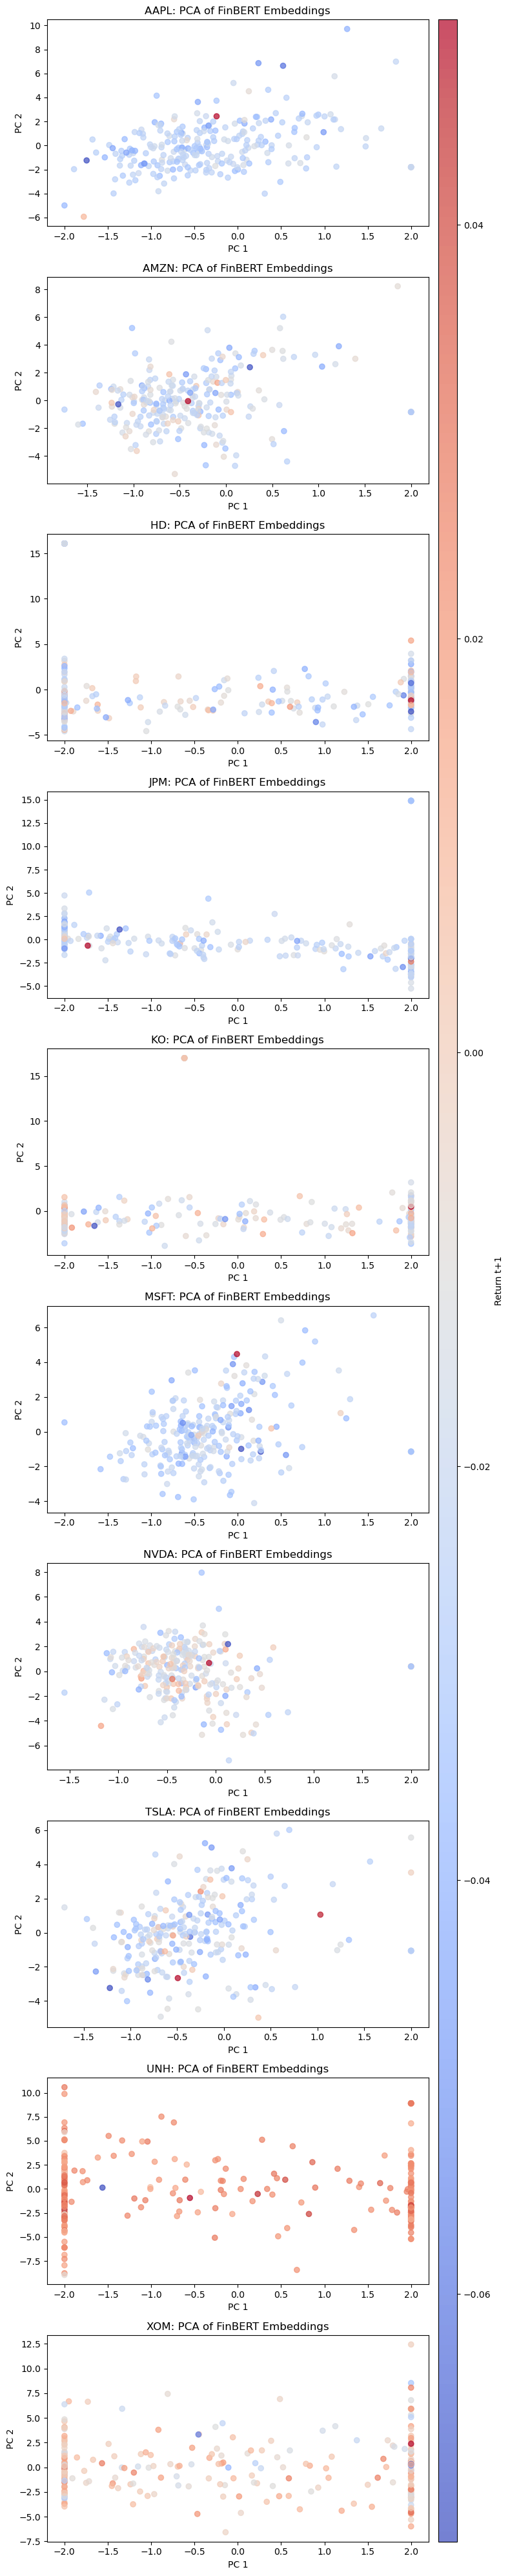

In [84]:
bert_cols = [col for col in df.columns if col.startswith("finbert_")]
tickers = df["ticker"].unique()
n_tickers = len(tickers)

# Set up subplot grid with room for colorbar
fig = plt.figure(figsize=(8, 4 * n_tickers))
gs = gridspec.GridSpec(n_tickers, 2, width_ratios=[20, 1])  # last column for colorbar

scatter_refs = []

for i, ticker in enumerate(tickers):
    df_t = df[df["ticker"] == ticker]
    if len(df_t) < 10:
        continue

    X = df_t[bert_cols]
    y = df_t["return_t+1"]

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)

    ax = fig.add_subplot(gs[i, 0])
    scatter = ax.scatter(pca_result[:, 0].clip(-2, 2), pca_result[:, 1], c=y, cmap="coolwarm", alpha=0.7)
    ax.set_title(f"{ticker}: PCA of FinBERT Embeddings")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

    scatter_refs.append(scatter)

# Add a single colorbar on the right
cbar_ax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(scatter_refs[-1], cax=cbar_ax)
cbar.set_label("Return t+1")

plt.tight_layout()
plt.show()


## Calculate other typical financial metrics
- Sharpe ratio
- Price momentum (3, 5, 10-day)
- Rolling volatility
- Relative strength
- Drawdown